In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv("./test.csv")

## General Data Exploration

Code for information about the data frames

In [3]:
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

summary(train)

data shape: (159256, 24)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
id,int64,0,0.00,159256,0.00,"159,255.00","79,627.50","45,973.39",0.00,1.00,2.00
age,int64,0,0.00,18,20.00,85.00,44.31,11.84,55.00,70.00,20.00
height(cm),int64,0,0.00,14,135.00,190.00,165.27,8.82,165.00,165.00,170.00
weight(kg),int64,0,0.00,28,30.00,130.00,67.14,12.59,60.00,65.00,75.00
waist(cm),float64,0,0.00,531,51.00,127.00,83.00,8.96,81.00,89.00,81.00
eyesight(left),float64,0,0.00,20,0.10,9.90,1.01,0.40,0.50,0.60,0.40
eyesight(right),float64,0,0.00,17,0.10,9.90,1.00,0.39,0.60,0.70,0.50
hearing(left),int64,0,0.00,2,1.00,2.00,1.02,0.15,1.00,2.00,1.00
hearing(right),int64,0,0.00,2,1.00,2.00,1.02,0.15,1.00,2.00,1.00
systolic,int64,0,0.00,112,77.00,213.00,122.50,12.73,135.00,146.00,118.00


Code for correlations heatmap

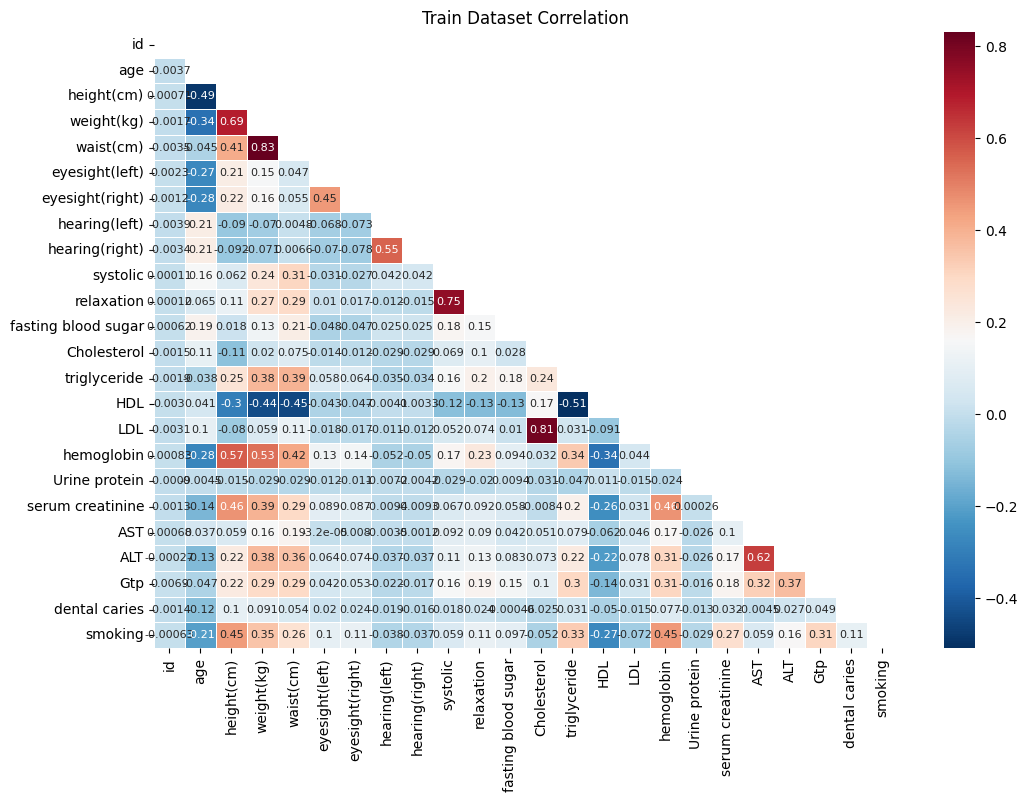

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='RdBu_r', annot=True,annot_kws={"size": 8})
    plt.title(title_name)
    plt.show()


plot_correlation_heatmap(train, 'Train Dataset Correlation')

## Model Exploration

In [8]:
from sklearn.model_selection import StratifiedKFold
class DataPrep:
    def __init__(self, train, test, idcol, target_col):
        self.train_ids = train.id #just the id column
        self.train_data = train #everything from train
        self.train = train.drop(columns=[idcol, target_col]) #just the data
        self.train_target = train[target_col] #Just the target
        self.test_ids = test.id #Test IDs
        self.test = test.drop(columns=[idcol]) #Just the test data
        self.normalize()
        self.SKfold(10)

    def SKfold(self, splits):
        self.skf = StratifiedKFold(n_splits=splits, shuffle=True)
        
    def drop_cols(self, columns):
        self.train = self.train.drop(columns=columns)
        self.test = self.test.drop(columns=columns)

    def normalize(self):
        self.ss = StandardScaler()
        new_train = self.ss.fit_transform(self.train)
        self.scaled_train = pd.DataFrame(new_train, index=self.train.index, columns=self.train.columns)
        new_test = self.ss.transform(self.test)
        self.scaled_test = pd.DataFrame(new_test, index=self.test.index, columns=self.test.columns)

## Testing using LightGBM Model

In [19]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

scores = []

train = pd.read_csv('./train.csv')
test = pd.read_csv("./test.csv")

data = DataPrep(train, test, 'id', 'smoking')



for fold, (train_idx, val_idx) in enumerate(data.skf.split(data.scaled_train, data.train_target)):
    X_train, y_train = data.scaled_train.iloc[train_idx], data.train_target.iloc[train_idx]
    X_valid, y_valid = data.scaled_train.iloc[val_idx], data.train_target.iloc[val_idx]
    train = lgb.Dataset(X_train, y_train)
    valid = lgb.Dataset(X_valid, y_valid, reference=train)

    num_rounds = 250
    params = {'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,}

    model = lgb.train(params, train, num_rounds)

    y_preds = model.predict(X_valid)
    score = roc_auc_score(y_valid, y_preds)
    scores.append(score)

print(scores)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62687, number of negative: 80643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2168
[LightGBM] [Info] Number of data points in the train set: 143330, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437361 -> initscore=-0.251878
[LightGBM] [Info] Start training from score -0.251878
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62687, number of negative: 80643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 143330, number of us

In [20]:
test_ids = test.id
p = model.predict(data.scaled_test)
predictions1 = pd.DataFrame({"id":test_ids, "smoking":p}, columns=['id', 'smoking'])
predictions1.to_csv('./submission1.csv', index=False)

## Trying with XGBoost

In [33]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

params = {'n_estimators':250, 'learning_rate':.05}

scores = []

model2 = xgb.XGBClassifier(**params)

data = DataPrep(pd.read_csv('./train.csv'), pd.read_csv('./test.csv'), 'id', 'smoking')

test = cross_val_score(model2, data.scaled_train, data.train_target, cv=5, scoring='roc_auc')
print(test.mean())

0.8656612423219892


In [30]:
test_ids = test.id
p = model2.predict_proba(data.scaled_test)
predictions2 = pd.DataFrame({"id":test_ids, "smoking":p}, columns=['id', 'smoking'])
predictions2.to_csv('./submission2.csv', index=False)

ValueError: Per-column arrays must each be 1-dimensional

In [35]:
from xgboost import XGBClassifier
import optuna

seed=42
data = DataPrep(pd.read_csv('./train.csv'), pd.read_csv('./test.csv'), 'id', 'smoking')
X, y = data.scaled_train, data.train_target

def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',500,750),
        'max_depth':  trial.suggest_int('max_depth',3,50),
        'min_child_weight': trial.suggest_float('min_child_weight', 2,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2,log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
        "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
    }
    xgbmodel_optuna = XGBClassifier(**params,random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")
    cv = cross_val_score(xgbmodel_optuna, X, y, cv = 4,scoring='roc_auc').mean()
    return cv
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100,timeout=5000)

c:\Users\mattc\Desktop\ml_web_comps\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-10-31 11:23:15,362] A new study created in memory with name: no-name-cc1605d8-0041-40f6-b3ad-4f0460e50ad3
c:\Users\mattc\Desktop\ml_web_comps\ml_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\mattc\Desktop\ml_web_comps\ml_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-

KeyboardInterrupt: 